# Parametros Generales

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Parámetros del sistema
FS = 48000          # Hz
FC = 4000           # Hz
BITS_PER_SYMBOL = 3
SPS = 128           # Samples per symbol
BETA = 0.35
SPAN = 8            # Duración filtro RRC en símbolos

# Símbolos por segundo resultantes:
RS = FS // SPS      # = 48000/128 = 375 sps

# Generacion de bits

In [173]:
def generate_bits(n_bits, rng=None):
    """
    Genera una secuencia de bits aleatorios (0/1).

    Parámetros:
        n_bits : int
            Número de bits a generar.
        rng : np.random.Generator o None
            Generador aleatorio. Si es None, se crea uno nuevo.

    Retorna:
        bits : ndarray de shape (n_bits,)
            Arreglo de bits 0/1 (dtype=int).
    """
    if rng is None:
        rng = np.random.default_rng()
    bits = rng.integers(0, 2, size=n_bits, dtype=int)
    return bits

# Ejemplo de uso
n_bits = 10*10 
bits = generate_bits(n_bits)
print(bits)


[0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1
 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1
 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1]


# Bits a Simbolos 8psk

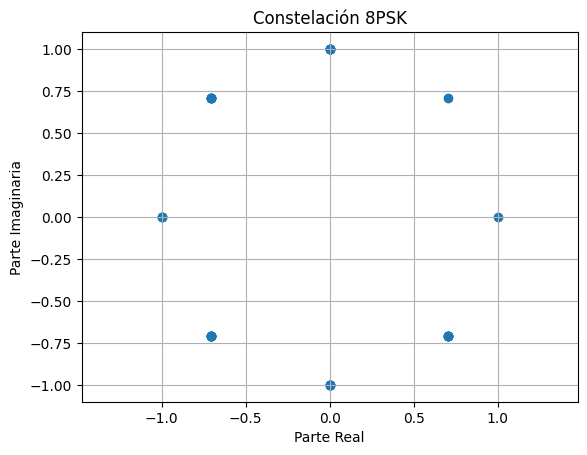

In [174]:
def bits_to_symbols_8psk(bits):
    """
    Mapea una secuencia de bits a símbolos 8PSK sobre el círculo unitario.
    Usa agrupación de 3 bits por símbolo con mapeo Gray sencillo.

    Parámetros:
        bits : ndarray de enteros (0/1), shape (N,)

    Retorna:
        symbols : ndarray complejo, shape (N_symbols,)
            Símbolos 8PSK en el círculo unitario.
    """
    # Asegurar que la longitud sea múltiplo de 3
    n_triples = len(bits) // 3
    bits = bits[:3 * n_triples]
    bits_reshaped = bits.reshape(-1, 3)

    # Convertir cada grupo de 3 bits a un índice 0..7
    indices = bits_reshaped[:, 0] * 4 + bits_reshaped[:, 1] * 2 + bits_reshaped[:, 2] * 1

    # Mapeo Gray opcional (puedes ajustar si quieres otro mapa)
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])  # ejemplo
    gray_indices = gray_map[indices]

    # Fase para cada símbolo (8PSK → 8 fases uniformes)
    phases = 2 * np.pi * gray_indices / 8.0

    # Símbolos complejos en el círculo unitario
    symbols = np.exp(1j * phases)
    return symbols

# Ejemplo de uso
symbols = bits_to_symbols_8psk(bits)
# Graficar
plt.figure()
plt.scatter(np.real(symbols), np.imag(symbols))
plt.title("Constelación 8PSK")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.show()

# FIltro SRRC

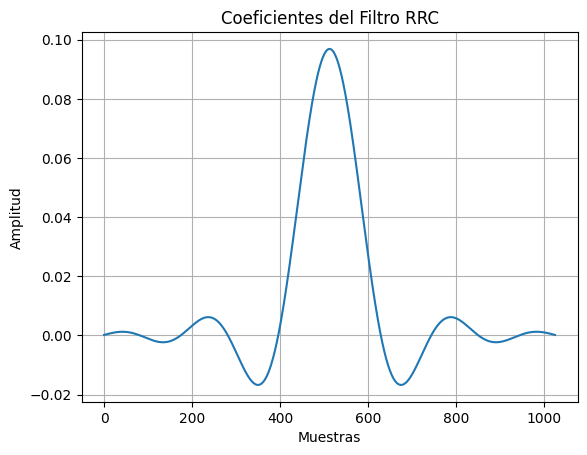

In [175]:
def rrc_filter(beta, span, sps):
    """
    Genera los coeficientes de un filtro Raised-Cosine Raíz (RRC/SRRC).

    Parámetros:
        beta : float
            Roll-off del filtro (0 < beta <= 1).
        span : int
            Duración del filtro en número de símbolos (ej: 6, 8, 10).
        sps : int
            Muestras por símbolo (Samples Per Symbol).

    Retorna:
        h : ndarray de floats, shape (span*sps + 1,)
            Coeficientes del filtro RRC.
    """
    N = span * sps
    t = np.arange(-N/2, N/2 + 1) / sps  # tiempo en unidades de T_símbolo

    h = np.zeros_like(t, dtype=float)
    for i, ti in enumerate(t):
        if np.isclose(ti, 0.0):
            h[i] = 1.0 - beta + (4 * beta / np.pi)
        elif np.isclose(abs(ti), 1/(4*beta)):
            # punto singular tratado aparte
            h[i] = (beta/np.sqrt(2)) * (
                ((1 + 2/np.pi) * np.sin(np.pi/(4*beta))) +
                ((1 - 2/np.pi) * np.cos(np.pi/(4*beta)))
            )
        else:
            num = np.sin(np.pi * ti * (1 - beta)) + \
                  4 * beta * ti * np.cos(np.pi * ti * (1 + beta))
            den = np.pi * ti * (1 - (4 * beta * ti)**2)
            h[i] = num / den

    # Normalizar energía (opcional pero recomendable)
    h = h / np.sqrt(np.sum(h**2))
    return h

# Ejemplo de uso
rrc_coeffs = rrc_filter(BETA, SPAN, SPS)
plt.figure()
plt.plot(rrc_coeffs)
plt.title("Coeficientes del Filtro RRC")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Agregar Ceros entre simbolos

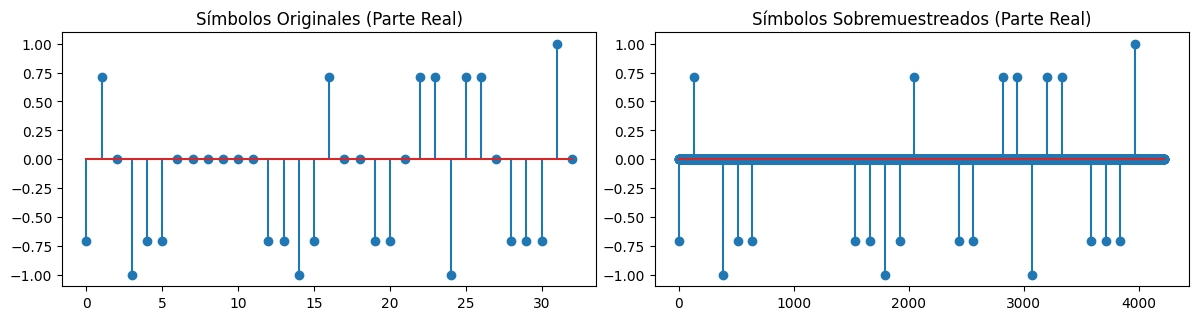

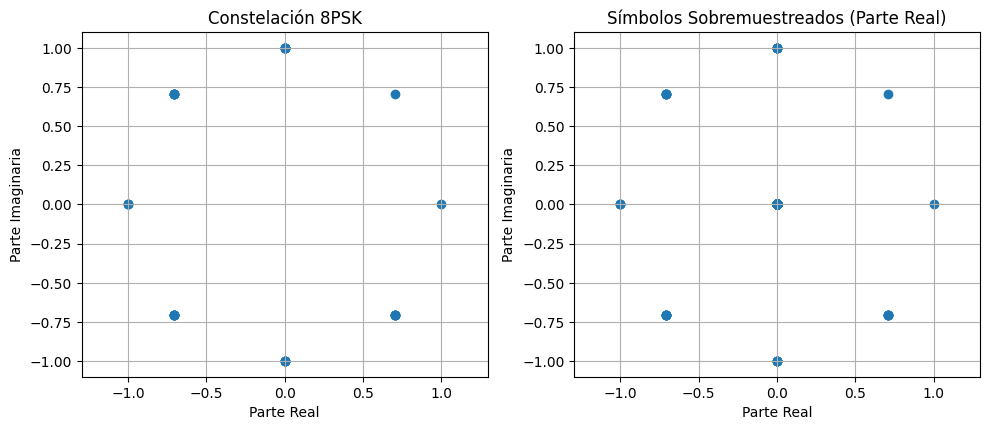

In [176]:
def upsample_symbols(symbols, sps):
    """
    Sobremuestrea los símbolos insertando (sps-1) ceros entre ellos.

    Parámetros:
        symbols : ndarray complejo, shape (N_symbols,)
        sps : int
            Muestras por símbolo.

    Retorna:
        x_upsampled : ndarray complejo, shape (N_symbols * sps,)
    """
    n = len(symbols)
    x_upsampled = np.zeros(n * sps, dtype=complex)
    x_upsampled[::sps] = symbols
    
    return x_upsampled
# Ejemplo de uso
x_upsampled = upsample_symbols(symbols, SPS)

# Graficar comparacion
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.stem(np.real(symbols))
plt.title("Símbolos Originales (Parte Real)")
plt.subplot(2, 2, 2)
plt.stem(np.real(x_upsampled))
plt.title("Símbolos Sobremuestreados (Parte Real)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.scatter(np.real(symbols), np.imag(symbols))
plt.title("Constelación 8PSK")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.subplot(2,2,2)
plt.scatter(np.real(x_upsampled), np.imag(x_upsampled))
plt.title("Símbolos Sobremuestreados (Parte Real)")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.tight_layout()
plt.show()


# Conversor de bits a coseno levantado

In [177]:
def bits_to_rrc_waveform(bits, beta, span, sps):
    """
    Convierte bits → símbolos 8PSK → sobremuestreo → filtrado RRC,
    obteniendo la señal en banda base con pulso SRRC.

    Parámetros:
        bits : ndarray de enteros (0/1)
        beta : float
        span : int
        sps : int

    Retorna:
        tx_bb : ndarray complejo
            Señal en banda base (I + jQ) filtrada con RRC.
        rrc_taps : ndarray float
            Coeficientes del filtro RRC usado.
        symbols : ndarray complejo
            Símbolos 8PSK antes del filtrado (para depuración).
    """
    # 1) bits → símbolos 8PSK
    symbols = bits_to_symbols_8psk(bits)

    # 2) diseñar filtro RRC
    rrc_taps = rrc_filter(beta, span, sps)

    # 3) sobremuestrear símbolos
    x_up = upsample_symbols(symbols, sps)

    # 4) filtrar (pulso con coseno levantado)
    tx_bb = np.convolve(x_up, rrc_taps, mode='full')

    return tx_bb, rrc_taps, symbols



# Ejemplo de uso 

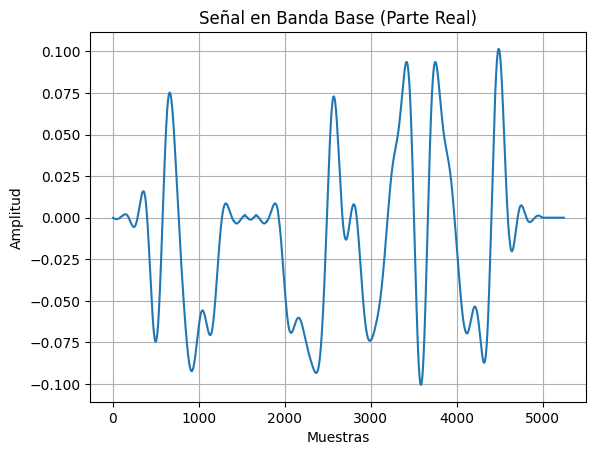

In [178]:
# 1. Generar bits
bits = bits
# 2. Obtener señal en banda base SRRC
tx_bb, rrc_taps, symbols = bits_to_rrc_waveform(bits, BETA, SPAN, SPS)

# tx_bb es tu señal “coseno levantado” en banda base (compleja)
# Luego podrás llevarla a banda pasante (audio) con una portadora cos/sin
# Graficar o guardar tx_bb según necesites
plt.figure()
plt.plot(np.real(tx_bb))
plt.title("Señal en Banda Base (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Generar Portadora

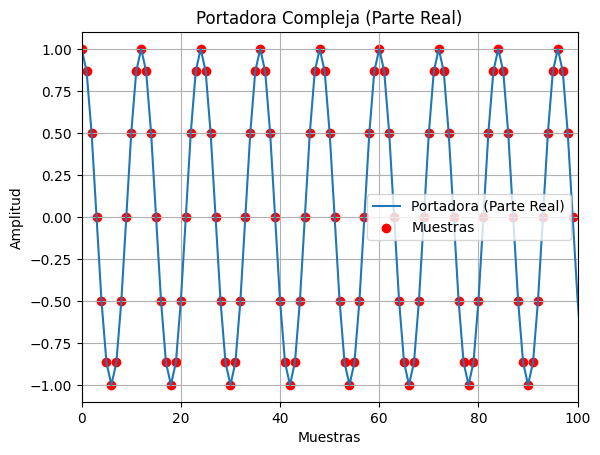

In [179]:
def generate_carrier(fc, fs, n_samples):
    """
    Genera una portadora compleja e^{j2πf_c t}.

    Parámetros:
        fc : float
            Frecuencia de la portadora en Hz.
        fs : float
            Frecuencia de muestreo.
        n_samples : int
            Número de muestras a generar.

    Retorna:
        carrier : ndarray complejo de shape (n_samples,)
    """
    t = np.arange(n_samples) / fs
    carrier = np.exp(1j * 2 * np.pi * fc * t)
    return carrier
# Ejemplo de uso
fc = 4000  # frecuencia de la portadora en Hz

carrier = generate_carrier(fc, FS, len(tx_bb))
# Graficar la portadora
plt.figure()
plt.plot(np.real(carrier), label='Portadora (Parte Real)')
plt.scatter(np.arange(0, 100), np.real(carrier[:100]), color='red', label='Muestras')
plt.xlim(0, 100)
plt.title("Portadora Compleja (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()


# Funcion Moduladora

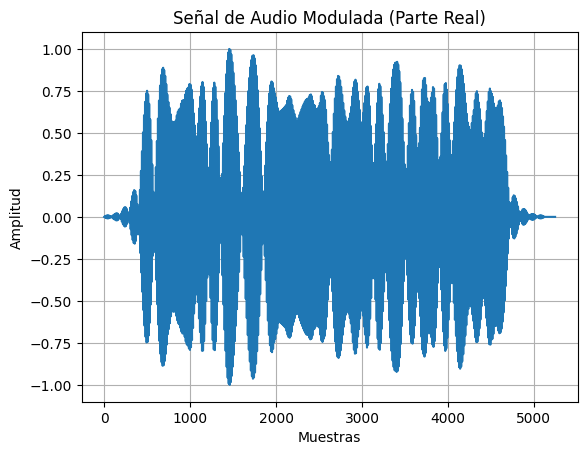

In [180]:
def modulate_to_passband(tx_bb, fc, fs):
    """
    Modula una señal de banda base (compleja) hacia banda pasante real para audio.

    Parámetros:
        tx_bb : ndarray complejo
            Señal en banda base (SRRC) I+jQ.
        fc : float
            Frecuencia de portadora en Hz.
        fs : float
            Frecuencia de muestreo en Hz.

    Retorna:
        tx_audio : ndarray float
            Señal real modulada lista para reproducir como audio.
    """
    n_samples = len(tx_bb)
    carrier = generate_carrier(fc, fs, n_samples)
    
    # Multiplicación complejo × complejo → señal analógica compleja
    tx_passband_complex = tx_bb * carrier
    
    # Sacar parte real → audio físico
    tx_audio = np.real(tx_passband_complex)

    # Normalizar para evitar clipping
    tx_audio /= np.max(np.abs(tx_audio) + 1e-12)

    return tx_audio
# Ejemplo de uso
tx_audio = modulate_to_passband(tx_bb, fc, FS)
# Graficar la señal de audio modulada
plt.figure()
plt.plot(tx_audio)
plt.title("Señal de Audio Modulada (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Generar audio

In [181]:

def play_audio(signal, fs):
    """
    Muestra un reproductor de audio para la señal dada.

    Parámetros:
        signal : ndarray float
        fs : int
            Frecuencia de muestreo.
    """
    return Audio(signal.astype(np.float32), rate=fs)


# Uso

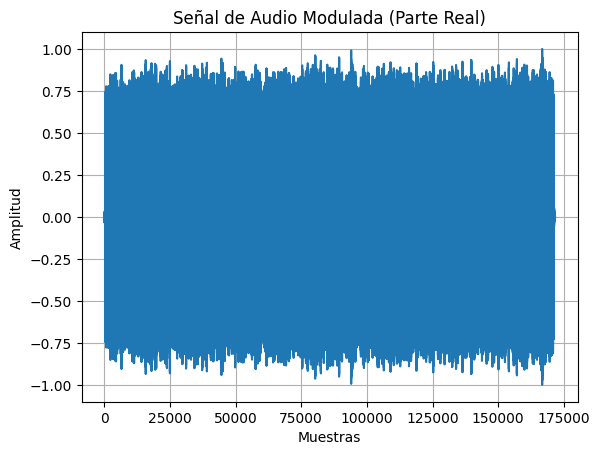

In [182]:
# --- 1. Generar bits ---
bits = generate_bits(4000)

# --- 2. Bits → señal SRRC en banda base ---
tx_bb, rrc_taps, symbols = bits_to_rrc_waveform(
    bits,
    beta=BETA,
    span=SPAN,
    sps=SPS
)

# --- 3. Modulación a banda pasante ---
fc = 4000     # Frecuencia de portadora en Hz (tú la puedes cambiar)
tx_audio = modulate_to_passband(tx_bb, fc, FS)
# --- 4. Graficar señal modulada ---
plt.figure()
plt.plot(tx_audio)
plt.title("Señal de Audio Modulada (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()
# --- 5. Reproducir audio ---
play_audio(tx_audio, FS)



# Demodulacion Prueba

In [183]:
def downconvert_to_baseband(rx_audio, fc, fs):
    """
    Convierte una señal real en banda pasante a banda base compleja.

    Parámetros:
        rx_audio : ndarray float
            Señal de audio recibida (real).
        fc : float
            Frecuencia de portadora (Hz).
        fs : float
            Frecuencia de muestreo (Hz).

    Retorna:
        rx_bb : ndarray complejo
            Señal en banda base (I + jQ).
    """
    n = len(rx_audio)
    t = np.arange(n) / fs
    carrier = np.exp(-1j * 2 * np.pi * fc * t)
    rx_bb = rx_audio * carrier
    return rx_bb
def sample_symbols_after_rrc(z, rrc_taps, sps, n_symbols=None):
    """
    Toma las muestras en los instantes de símbolo a la salida
    del filtro casado (RRC en RX).

    Parámetros:
        z : ndarray complejo
            Señal filtrada (matched filter output).
        rrc_taps : ndarray float
        sps : int
            Muestras por símbolo.
        n_symbols : int o None
            Cantidad de símbolos a extraer. Si es None, se toma todo lo posible.

    Retorna:
        symbols_rx : ndarray complejo
            Símbolos muestreados.
    """
    total_delay = len(rrc_taps) - 1
    start = total_delay

    symbols_rx = z[start::sps]

    if n_symbols is not None:
        symbols_rx = symbols_rx[:n_symbols]

    return symbols_rx

def symbols_8psk_to_bits(symbols):
    """
    Convierte símbolos 8PSK (complejos) a bits usando
    el mismo mapeo Gray que en el transmisor.

    Parámetros:
        symbols : ndarray complejo

    Retorna:
        bits_rx : ndarray int (0/1)
    """
    # Fase entre 0 y 2π
    phases = np.angle(symbols)
    phases = (phases + 2 * np.pi) % (2 * np.pi)

    # Índices 0..7 según la fase
    indices_hat = np.round(phases * 8 / (2 * np.pi)).astype(int) % 8

    # Mismo Gray map que en TX
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])

    # Inversa del Gray map
    inv_gray = np.zeros_like(gray_map)
    inv_gray[gray_map] = np.arange(8)

    m = inv_gray[indices_hat]  # índices binarios 0..7

    # Convertir índices a 3 bits (b2 b1 b0)
    b2 = (m >> 2) & 1
    b1 = (m >> 1) & 1
    b0 = m & 1

    bits_rx = np.column_stack((b2, b1, b0)).reshape(-1).astype(int)
    return bits_rx
def matched_filter(rx_bb, rrc_taps):
    """
    Aplica el filtro casado (mismo RRC que en TX).

    Parámetros:
        rx_bb : ndarray complejo
            Señal en banda base después de downconversion.
        rrc_taps : ndarray float
            Coeficientes del filtro RRC usado en el TX.

    Retorna:
        z : ndarray complejo
            Señal filtrada (salida del filtro casado).
    """
    z = np.convolve(rx_bb, rrc_taps, mode='full')
    return z

def quick_demod_8psk(rx_audio, fc, fs, rrc_taps, sps, n_symbols=None):
    """
    Demodulador rápido para prueba en lazo cerrado (ideal):
    - Downconversion
    - Matched filter (RRC)
    - Muestreo por símbolo
    - Decisión 8PSK → bits

    Parámetros:
        rx_audio : ndarray float
            Señal de audio recibida (real).
        fc : float
            Frecuencia de portadora.
        fs : float
            Frecuencia de muestreo.
        rrc_taps : ndarray float
        sps : int
        n_symbols : int o None
            Número de símbolos esperados (si se conoce).

    Retorna:
        bits_rx : ndarray int
            Bits recuperados.
        symbols_rx : ndarray complejo
            Símbolos detectados antes de decisión.
    """
    # 1. Banda base
    rx_bb = downconvert_to_baseband(rx_audio, fc, fs)

    # 2. Filtro casado
    z = matched_filter(rx_bb, rrc_taps)

    # 3. Muestreo
    symbols_rx = sample_symbols_after_rrc(z, rrc_taps, sps, n_symbols=n_symbols)

    # 4. Decisión a bits
    bits_rx = symbols_8psk_to_bits(symbols_rx)

    return bits_rx, symbols_rx
# --- Parámetros (los mismos que antes) ---
FS = 48000
FC = 4000
BITS_PER_SYMBOL = 3
SPS = 128
BETA = 0.35
SPAN = 8

# --- 1. Generar bits ---
n_bits = 100  # por ejemplo, múltiplo de 3 si quieres exacto
bits_tx = generate_bits(n_bits)

# --- 2. TX: bits → SRRC banda base ---
tx_bb, rrc_taps, symbols_tx = bits_to_rrc_waveform(bits_tx, BETA, SPAN, SPS)

# --- 3. TX: modulación a banda pasante ---
tx_audio = modulate_to_passband(tx_bb, FC, FS)

# (aquí podrías hacer play_audio(tx_audio, FS) si quieres o grabarlo en archivo)

# --- 4. RX ideal: usar el mismo audio como recibido ---
rx_audio = tx_audio.copy()  # en la práctica vendría del micrófono

# Cuántos símbolos esperamos (mismo que en TX)
n_symbols_tx = len(symbols_tx)

bits_rx, symbols_rx = quick_demod_8psk(
    rx_audio,
    fc=FC,
    fs=FS,
    rrc_taps=rrc_taps,
    sps=SPS,
    n_symbols=n_symbols_tx
)

# --- 5. Comparar BER ---
n_bits_cmp = min(len(bits_tx), len(bits_rx))
ber = np.mean(bits_tx[:n_bits_cmp] != bits_rx[:n_bits_cmp])
print("Bits transmitidos:", bits_tx[:n_bits_cmp])
print("Bits recibidos:   ", bits_rx[:n_bits_cmp])
print("BER (lazo ideal):", ber)


Bits transmitidos: [1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0
 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1
 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0]
Bits recibidos:    [1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0
 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1
 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0]
BER (lazo ideal): 0.0
